# Cryptocurrency Time Series Forecasting Using LSTM & GRU

# Intruduction of the LSTM model

### Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (e.g. images), but also entire sequences of data (such as speech or video inputs).

### LSTM models are able to store information over a period of time. In order words, they have a memory capacity. Remember that LSTM stands for Long Short-Term Memory Model.

### This characteristic is extremely useful when we deal with Time-Series or Sequential Data. When using an LSTM model we are free and able to decide what information will be stored and what discarded. We do that using the “gates”. The deep understanding of the LSTM is outside the scope of this post but if you are interested in learning more, have a look at the references at the end of this post.

### Import Libraries

In [219]:
import os
import pandas as pd
import numpy as np
import math
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

### Import Dataset & Preprocessing


In [220]:
bitcoindf = pd.read_csv('../data/Bitcoin/BTC-USD-NEW.csv')
bitcoindf = bitcoindf.sort_values('date')
bitcoindf = bitcoindf[bitcoindf.columns[1:]]
bitcoindf.head()

,date,open,high,low,close,adj_close,volume
0,2015-09-13,235.242004,235.934998,229.332001,230.511993,230.511993,18478800.0
1,2015-09-14,230.608994,232.440002,227.960999,230.643997,230.643997,20997800.0
2,2015-09-15,230.492004,259.182007,229.822006,230.304001,230.304001,19177800.0
3,2015-09-16,230.250000,231.214996,227.401993,229.091003,229.091003,20144200.0
4,2015-09-17,229.076004,230.285004,228.925995,229.809998,229.809998,18935400.0


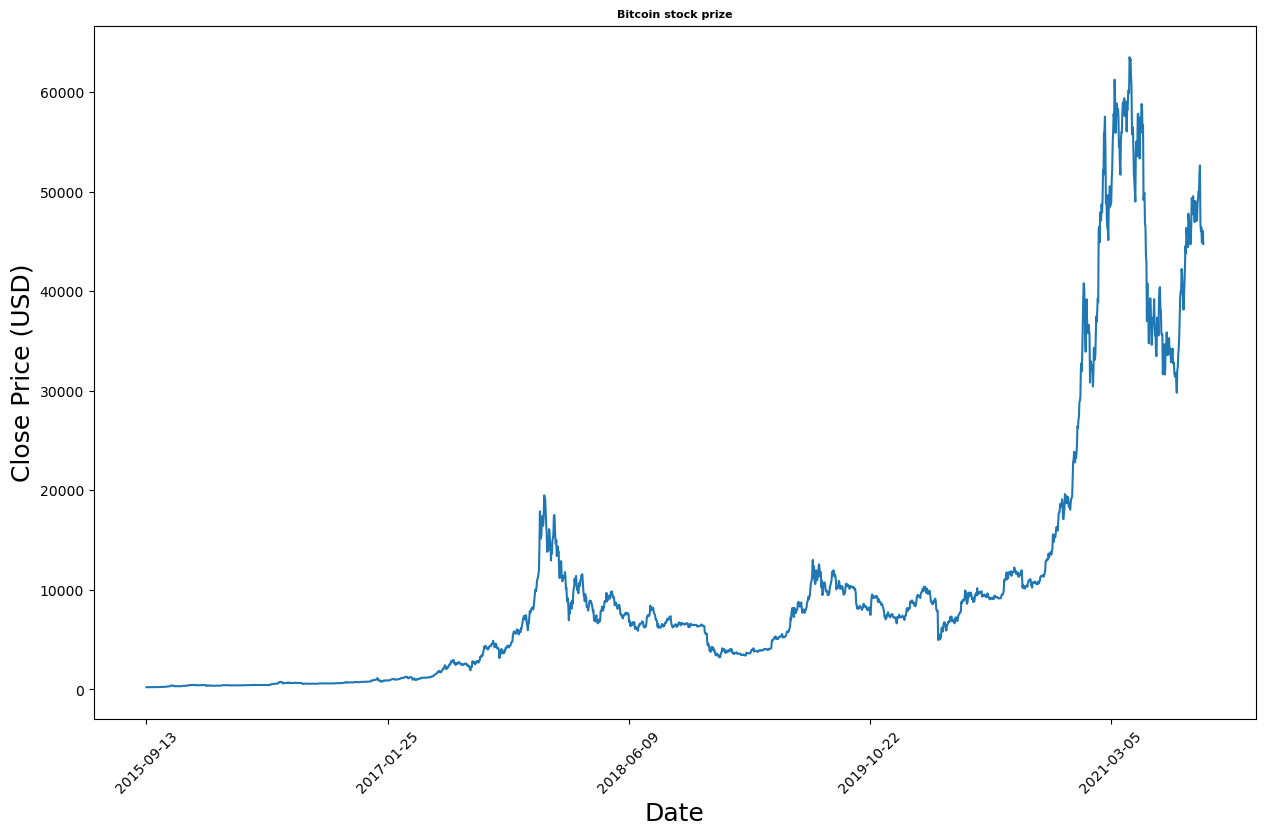

In [221]:
plt.figure(figsize = (15, 9))
plt.plot(bitcoindf[['close']])
plt.xticks(range(0, bitcoindf.shape[0], 500), bitcoindf['date'].loc[::500], rotation = 45)
plt.title('Bitcoin stock prize', fontsize = 8, fontweight = 'bold')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price (USD)', fontsize = 18)  
plt.show()

### Normalize Data

In [222]:
price = bitcoindf[['close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 2192
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2193 non-null   float64
dtypes: float64(1)
memory usage: 34.3 KB


In [223]:
scaler = MinMaxScaler(feature_range = (-1, 1))
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))

/var/folders/g9/s15kjggj0bb9t_61f58dny800000gn/T/ipykernel_4758/2850328666.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [224]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[: train_set_size, :-1, :]
    y_train = data[: train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)


x_train.shape =  (1738, 19, 1)
y_train.shape =  (1738, 1)
x_test.shape =  (435, 19, 1)
y_test.shape =  (435, 1)


In [225]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [226]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

### LSTM

In [227]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [228]:
model = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)
criterion = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)

In [229]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5199045538902283
Epoch  1 MSE:  0.3083359897136688
Epoch  2 MSE:  0.10039380937814713
Epoch  3 MSE:  0.04574834182858467
Epoch  4 MSE:  0.05584583058953285
Epoch  5 MSE:  0.014715799130499363
Epoch  6 MSE:  0.018701639026403427
Epoch  7 MSE:  0.030545396730303764
Epoch  8 MSE:  0.03270111605525017
Epoch  9 MSE:  0.026498107239603996
Epoch  10 MSE:  0.018144382163882256
Epoch  11 MSE:  0.013469832018017769
Epoch  12 MSE:  0.014797273091971874
Epoch  13 MSE:  0.01931147091090679
Epoch  14 MSE:  0.021817326545715332
Epoch  15 MSE:  0.02018139511346817
Epoch  16 MSE:  0.016525283455848694
Epoch  17 MSE:  0.013862669467926025
Epoch  18 MSE:  0.013432861305773258
Epoch  19 MSE:  0.014625678770244122
Epoch  20 MSE:  0.016129285097122192
Epoch  21 MSE:  0.016905393451452255
Epoch  22 MSE:  0.01658755913376808
Epoch  23 MSE:  0.015445740893483162
Epoch  24 MSE:  0.014124047011137009
Epoch  25 MSE:  0.013281989842653275
Epoch  26 MSE:  0.013247747905552387
Epoch  27 MSE:  0.0138

In [230]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

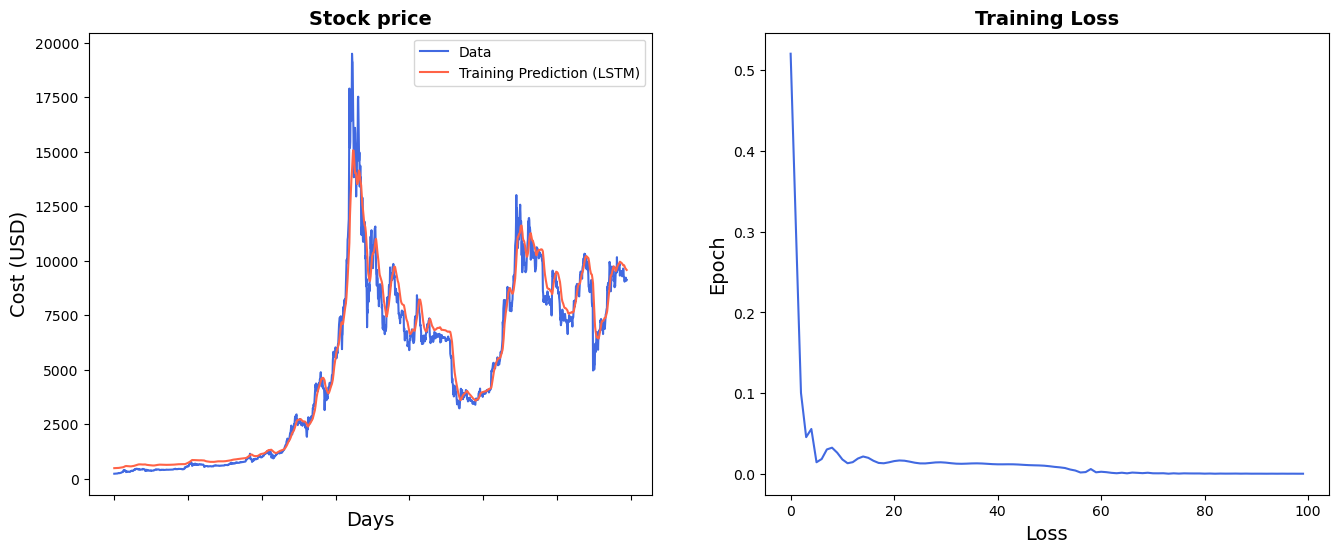

In [231]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace = 0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label = 'Data', color = 'royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label = 'Training Prediction (LSTM)', color = 'tomato')
ax.set_title('Stock price', size = 14, fontweight = 'bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Cost (USD)', size = 14)
ax.set_xticklabels('', size = 10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data = hist, color = 'royalblue')
ax.set_title('Training Loss', size = 14, fontweight = 'bold')
ax.set_xlabel('Loss', size = 14)
ax.set_ylabel('Epoch', size = 14)
fig.set_figheight(6)
fig.set_figwidth(16)

In [232]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 721.16 RMSE
Test Score: 120.32 RMSE


In [233]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

original = scaler.inverse_transform(price['close'].values.reshape(-1, 1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis = 1)
predictions = np.append(predictions, original, axis = 1)
result = pd.DataFrame(predictions)

In [234]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[0], mode = 'lines', name = 'Train prediction')))
fig.add_trace(go.Scatter(x = result.index, y = result[1], mode = 'lines', name = 'Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[2], mode = 'lines', name = 'Actual Value')))
fig.update_layout(xaxis = dict(showline = True, showgrid = True, showticklabels = False, linecolor = 'white', linewidth = 2), yaxis = dict(title_text = 'Close (USD)', titlefont = dict(family = 'Rockwell', size = 12, color = 'white'), showline = True, showgrid = True, showticklabels = True, linecolor = 'white', linewidth = 2, ticks = 'outside', tickfont = dict(family = 'Rockwell', size = 12, color = 'white',),), showlegend = True, template = 'plotly_dark')

annotations = []
annotations.append(dict(xref = 'paper', yref = 'paper', x = 0.0, y = 1.05, xanchor = 'left', yanchor = 'bottom', text = 'Results (LSTM)', font = dict(family = 'Rockwell', size = 26, color = 'white'), showarrow = False))

fig.update_layout(annotations = annotations)

fig.show()

### GRU

In [235]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [236]:
model = GRU(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers)
criterion = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)


In [237]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.7175965905189514
Epoch  1 MSE:  0.30176496505737305
Epoch  2 MSE:  0.06240149959921837
Epoch  3 MSE:  0.03337865695357323
Epoch  4 MSE:  0.09993705153465271
Epoch  5 MSE:  0.035925161093473434
Epoch  6 MSE:  0.01033477857708931
Epoch  7 MSE:  0.03777178004384041
Epoch  8 MSE:  0.05605894327163696
Epoch  9 MSE:  0.04698799178004265
Epoch  10 MSE:  0.025225218385457993
Epoch  11 MSE:  0.01031422521919012
Epoch  12 MSE:  0.012967686168849468
Epoch  13 MSE:  0.025571946054697037
Epoch  14 MSE:  0.029932264238595963
Epoch  15 MSE:  0.021637504920363426
Epoch  16 MSE:  0.011728248558938503
Epoch  17 MSE:  0.00918485876172781
Epoch  18 MSE:  0.01334457565099001
Epoch  19 MSE:  0.018324945122003555
Epoch  20 MSE:  0.019446101039648056
Epoch  21 MSE:  0.01612948626279831
Epoch  22 MSE:  0.011225956492125988
Epoch  23 MSE:  0.008472051471471786
Epoch  24 MSE:  0.009544933214783669
Epoch  25 MSE:  0.012547909282147884
Epoch  26 MSE:  0.013866383582353592
Epoch  27 MSE:  0.0120640

In [238]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

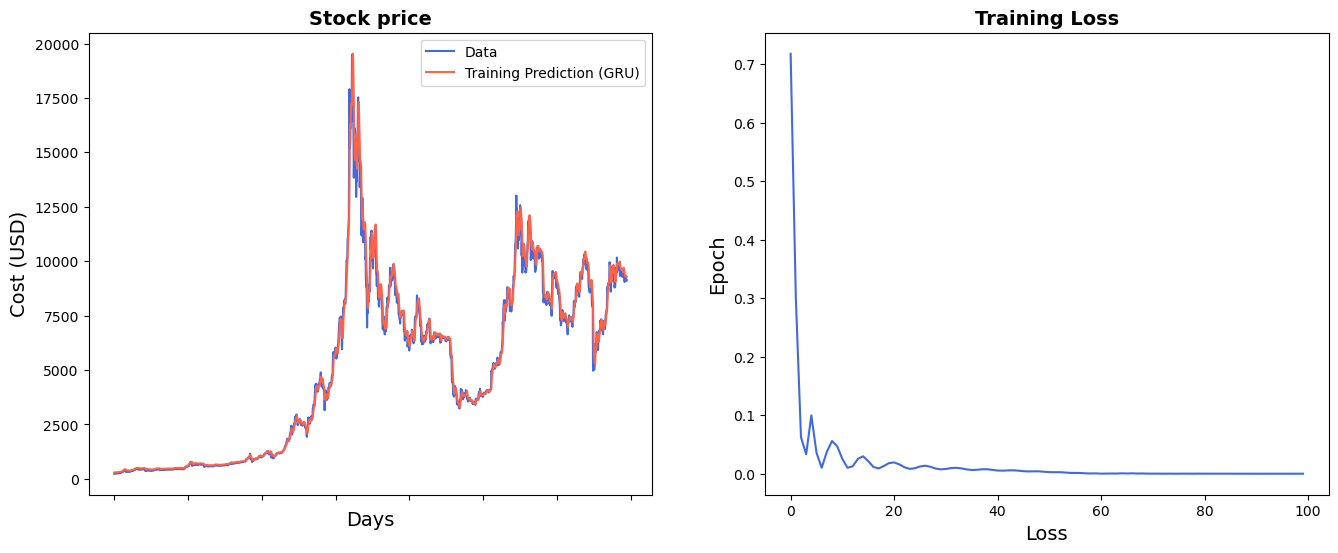

In [239]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace = 0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label = 'Data', color = 'royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label = 'Training Prediction (GRU)', color = 'tomato')
ax.set_title('Stock price', size = 14, fontweight = 'bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Cost (USD)', size = 14)
ax.set_xticklabels('', size = 10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data = hist, color = 'royalblue')
ax.set_title('Training Loss', size = 14, fontweight = 'bold')
ax.set_xlabel('Loss', size = 14)
ax.set_ylabel('Epoch', size = 14)
fig.set_figheight(6)
fig.set_figwidth(16)

In [240]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 420.22 RMSE
Test Score: 45.78 RMSE


In [241]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

original = scaler.inverse_transform(price['close'].values.reshape(-1, 1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis = 1)
predictions = np.append(predictions, original, axis = 1)
result = pd.DataFrame(predictions)

In [242]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[0], mode = 'lines', name = 'Train prediction')))
fig.add_trace(go.Scatter(x = result.index, y = result[1], mode = 'lines', name = 'Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x = result.index, y = result[2], mode = 'lines', name = 'Actual Value')))
fig.update_layout(xaxis = dict(showline = True, showgrid = True, showticklabels = False, linecolor = 'white', linewidth = 2), yaxis = dict(title_text = 'Close (USD)', titlefont = dict(family = 'Rockwell', size = 12, color = 'white'), showline = True, showgrid = True, showticklabels = True, linecolor = 'white', linewidth = 2, ticks = 'outside', tickfont = dict(family = 'Rockwell', size = 12, color = 'white',),), showlegend = True, template = 'plotly_dark')

annotations = []
annotations.append(dict(xref = 'paper', yref = 'paper', x = 0.0, y = 1.05, xanchor = 'left', yanchor = 'bottom', text = 'Results (GRU)', font = dict(family = 'Rockwell', size = 26, color = 'white'), showarrow = False))

fig.update_layout(annotations = annotations)

fig.show()

In [243]:
lstm = pd.DataFrame(lstm, columns = ['LSTM'])
gru = pd.DataFrame(gru, columns = ['GRU'])
result = pd.concat([lstm, gru], axis = 1, join = 'inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,721.155756,420.216574
Test RMSE,120.320158,45.783700
Train Time,9.029918,7.032798
